### Importing Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import anderson
from scipy.stats import kruskal
import statsmodels.api as sm
import pmdarima as pm

import numpy as np

from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings("ignore")


### Data Reading

In [2]:
d= pd.read_excel('SeoulBikeData.xlsx')
d['Date']= pd.to_datetime(d['Date'])
print(d.columns)

Index(['Date', 'Rented Bike Count', 'Hour', 'Temperature(°C)', 'Humidity(%)',
       'Wind speed (m/s)', 'Visibility (10m)', 'Dew point temperature(°C)',
       'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)', 'Seasons',
       'Holiday', 'Functioning Day'],
      dtype='object')


In [221]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Date                       8760 non-null   datetime64[ns]
 1   Rented Bike Count          8760 non-null   int64         
 2   Hour                       8760 non-null   int64         
 3   Temperature(°C)            8760 non-null   float64       
 4   Humidity(%)                8760 non-null   int64         
 5   Wind speed (m/s)           8760 non-null   float64       
 6   Visibility (10m)           8760 non-null   int64         
 7   Dew point temperature(°C)  8760 non-null   float64       
 8   Solar Radiation (MJ/m2)    8760 non-null   float64       
 9   Rainfall(mm)               8760 non-null   float64       
 10  Snowfall (cm)              8760 non-null   float64       
 11  Seasons                    8760 non-null   object        
 12  Holida

In [9]:
d.head()

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,2017-01-12,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,2017-01-12,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,2017-01-12,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,2017-01-12,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,2017-01-12,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


## Phase 1

### Part 1

Here we analyze the count of rented bikes.

#### Trend

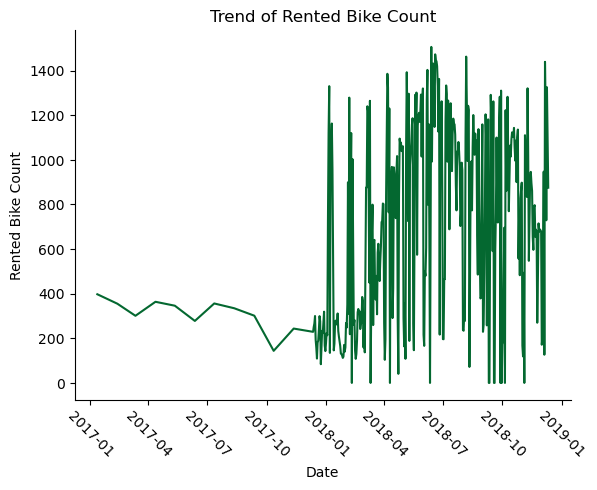

In [10]:
sns.lineplot(x=d['Date'], 
            y=d['Rented Bike Count'], 
            color='#046830', 
            ci= None
            )

# Set title and labels
plt.title('Trend of Rented Bike Count')
plt.xlabel('Date')
plt.ylabel('Rented Bike Count')

plt.xticks(rotation= -45)
# Remove unnecessary spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()


#### Histogram

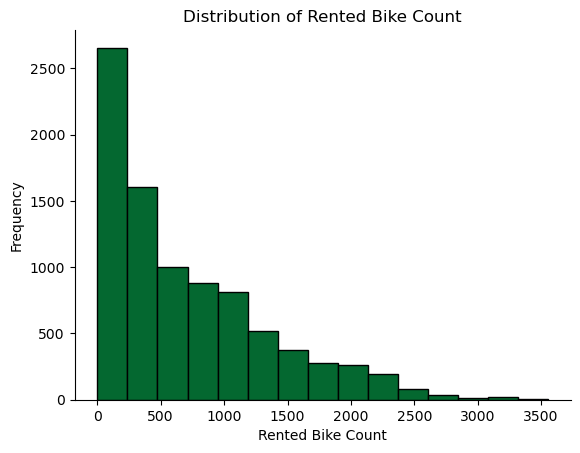

In [11]:

plt.hist(d['Rented Bike Count'], bins=15, color='#046830', edgecolor='black')

# Set title and labels
plt.title('Distribution of Rented Bike Count')
plt.xlabel('Rented Bike Count')
plt.ylabel('Frequency')

# Remove unnecessary spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Show the plot
plt.show();


We can see from the histogram that for most of the days, the bike demand has been less than 1000 bikes per day.
Also we have some days that the demand was higher than usual around 3000.

#### Hourly Trend

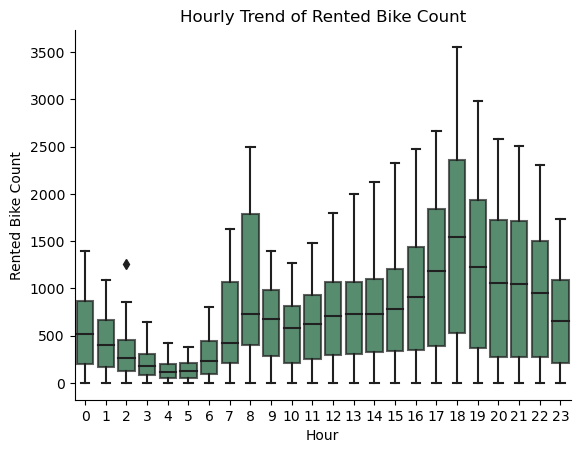

In [12]:

# Set the color palette
sns.set_palette(sns.color_palette(['#046830']))

sns.boxplot(x=d['Hour'], 
            y=d['Rented Bike Count'], 
            color='#046830', 
            boxprops=dict(alpha=.7))

# Set title and labels
plt.title('Hourly Trend of Rented Bike Count')
plt.xlabel('Hour')
plt.ylabel('Rented Bike Count')

# Remove unnecessary spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

We can see that the hourly demand for the bikes has two peaks. The first one is in the morning when people go to work and the second one is around the hour 19 at night when people come back from work.

#### Seasonal Trend

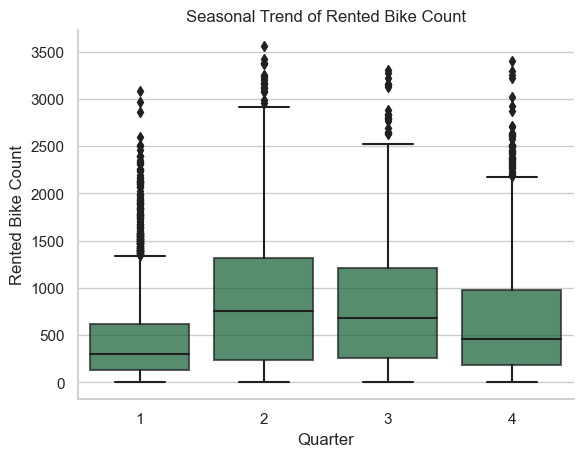

In [232]:
d['Quarter']= d['Date'].dt.quarter

sns.boxplot(x=d['Quarter'], 
            y=d['Rented Bike Count'], 
            color='#046830', 
            boxprops=dict(alpha=.7))

# Set title and labels
plt.title('Seasonal Trend of Rented Bike Count')
plt.xlabel('Quarter')
plt.ylabel('Rented Bike Count')

# Remove unnecessary spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show();

We can see that bikes has higher demand in summer and fall. Surprisingly, the demand in the spring is the lowest althogh the weather situation in this season is suitable for biking.

#### Weekly Trend

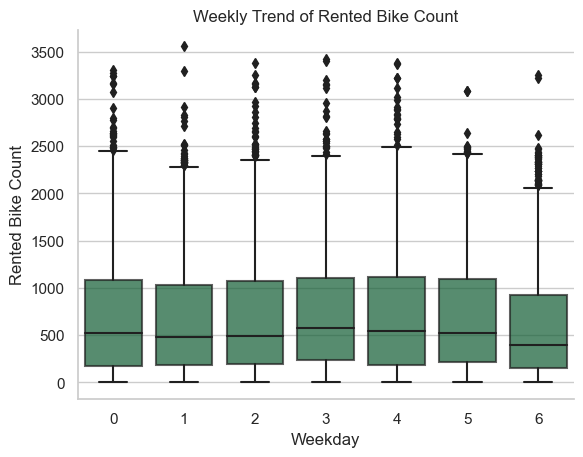

In [233]:
d['Weekday']= d.Date.dt.weekday

sns.boxplot(x=d['Weekday'], 
            y=d['Rented Bike Count'], 
            color='#046830', 
            boxprops=dict(alpha=.7))

# Set title and labels
plt.title('Weekly Trend of Rented Bike Count')
plt.xlabel('Weekday')
plt.ylabel('Rented Bike Count')

# Remove unnecessary spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()


We can see that the boxplot can't show the difference between the days well. So we use the simple line chart for this part.

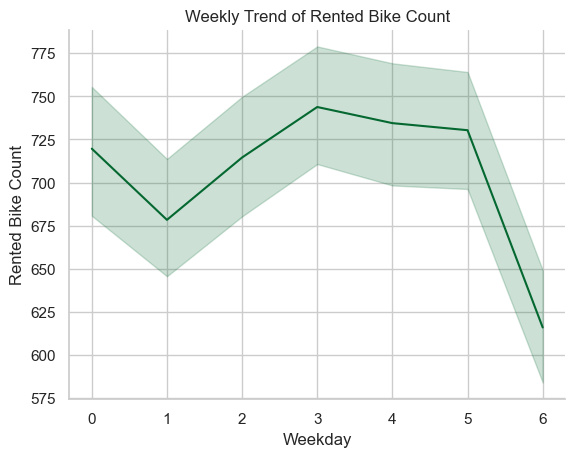

In [234]:
sns.lineplot(x=d['Weekday'], 
            y=d['Rented Bike Count'], 
            color='#046830', 
            )

# Set title and labels
plt.title('Weekly Trend of Rented Bike Count')
plt.xlabel('Weekday')
plt.ylabel('Rented Bike Count')

# Remove unnecessary spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()


We can see from the line chart that the demand for working days is usually higher than weeekends. Interestingly, we can see that people do not prefer to bike in the first working days as they may be still tired after the weekends! So the ending working days have the highest demand.

### Part 2

#### Checking Normality

from the previous part, we can see that the demand doesn't have normal distribution. We use Anderson-Darling test to validate this observation.

In [16]:

rented_bike_count = d['Rented Bike Count']

# Perform Anderson-Darling test
result = anderson(rented_bike_count)

# Display the test results in a table
columns = ['Statistic', 'Critical Values', 'Significance Levels']
data = [result.statistic, result.critical_values, result.significance_level]
table_data = pd.DataFrame(data, index=columns, columns=['Value'])

# Print the table
print("Anderson-Darling Test Results for 'Rented Bike Count':")
print(table_data)


Anderson-Darling Test Results for 'Rented Bike Count':
                                                   Value
Statistic                                     311.375046
Critical Values      [0.576, 0.656, 0.787, 0.918, 1.092]
Significance Levels          [15.0, 10.0, 5.0, 2.5, 1.0]


The null hypothesis for the Anderson test is that the sample has normal distribution. Since this hypothesis is strongly rejected since 311>>1.092, we can validate our observation that the demand doesn't have normal distribution. So in the next part, we use Kruskal-Wallis test to check demand difference between holidays and working days.

#### Holiday Effect

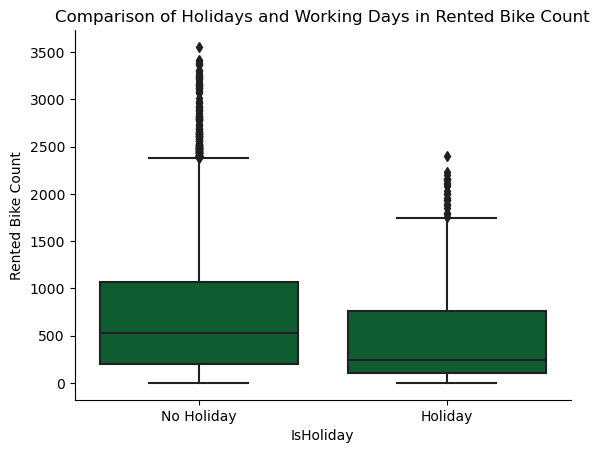

In [17]:
sns.boxplot(x=d['Holiday'], 
            y=d['Rented Bike Count'], 
            color='#046830', 
            )

# Set title and labels
plt.title('Comparison of Holidays and Working Days in Rented Bike Count')
plt.xlabel('IsHoliday')
plt.ylabel('Rented Bike Count')

# Remove unnecessary spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()


From the plot we can see that the bike demand on working days is higher than holidays. We the similar results in the weekly trend in the previous part. As also mentioned there, this fact shows that people mostly use bikes to go or come back from work.

In [18]:
holiday_data = [d['Rented Bike Count'][d['Holiday'] == 'Holiday'], d['Rented Bike Count'][d['Holiday'] == 'No Holiday']]

# Perform Kruskal-Wallis test
statistic, p_value = kruskal(*holiday_data)

# Display the test results in a table
columns = ['Statistic', 'p-value']
data = [statistic, p_value]
table_data = pd.DataFrame(data, index=columns, columns=['Value'])

# Print the table
print("Kruskal-Wallis Test Results for Rented Bike Count and Holiday:")
print(table_data)


Kruskal-Wallis Test Results for Rented Bike Count and Holiday:
                  Value
Statistic  7.188621e+01
p-value    2.279720e-17


This test is a non-parametric test and it's null hypothesis is that the medians of bike rental counts are equal across different holiday categories. We can see that the p-value is approximately zero, so we reject the null hypothesis and we can say that based on the test, the medians are not equal and there is a difference for the demand between holidays and working days.

### Part 3

#### Correlation Analysis

In [19]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Date                       8760 non-null   datetime64[ns]
 1   Rented Bike Count          8760 non-null   int64         
 2   Hour                       8760 non-null   int64         
 3   Temperature(°C)            8760 non-null   float64       
 4   Humidity(%)                8760 non-null   int64         
 5   Wind speed (m/s)           8760 non-null   float64       
 6   Visibility (10m)           8760 non-null   int64         
 7   Dew point temperature(°C)  8760 non-null   float64       
 8   Solar Radiation (MJ/m2)    8760 non-null   float64       
 9   Rainfall(mm)               8760 non-null   float64       
 10  Snowfall (cm)              8760 non-null   float64       
 11  Seasons                    8760 non-null   object        
 12  Holida

We first classify the features.

In [235]:
cols_numeric= d.select_dtypes([int, float]).columns.tolist()
print(d.select_dtypes([int, float]).columns)

Index(['Rented Bike Count', 'Hour', 'Temperature(°C)', 'Humidity(%)',
       'Wind speed (m/s)', 'Visibility (10m)', 'Dew point temperature(°C)',
       'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)', 'Quarter',
       'Weekday'],
      dtype='object')


We see some of these columns are not really numeric like hour, quarter, and weekday. We seperate them first.

In [236]:
cols_numeric_cat= ['Hour', 'Quarter', 'Weekday']
cols_numeric= list(set(cols_numeric)- set(cols_numeric_cat))

In [237]:
cols_cat= d.select_dtypes(['object']).columns.tolist()

# we also have quarter in the season column so we remove that
cols_cat= list(set(cols_cat)| set(cols_numeric_cat)- {'Quarter'})

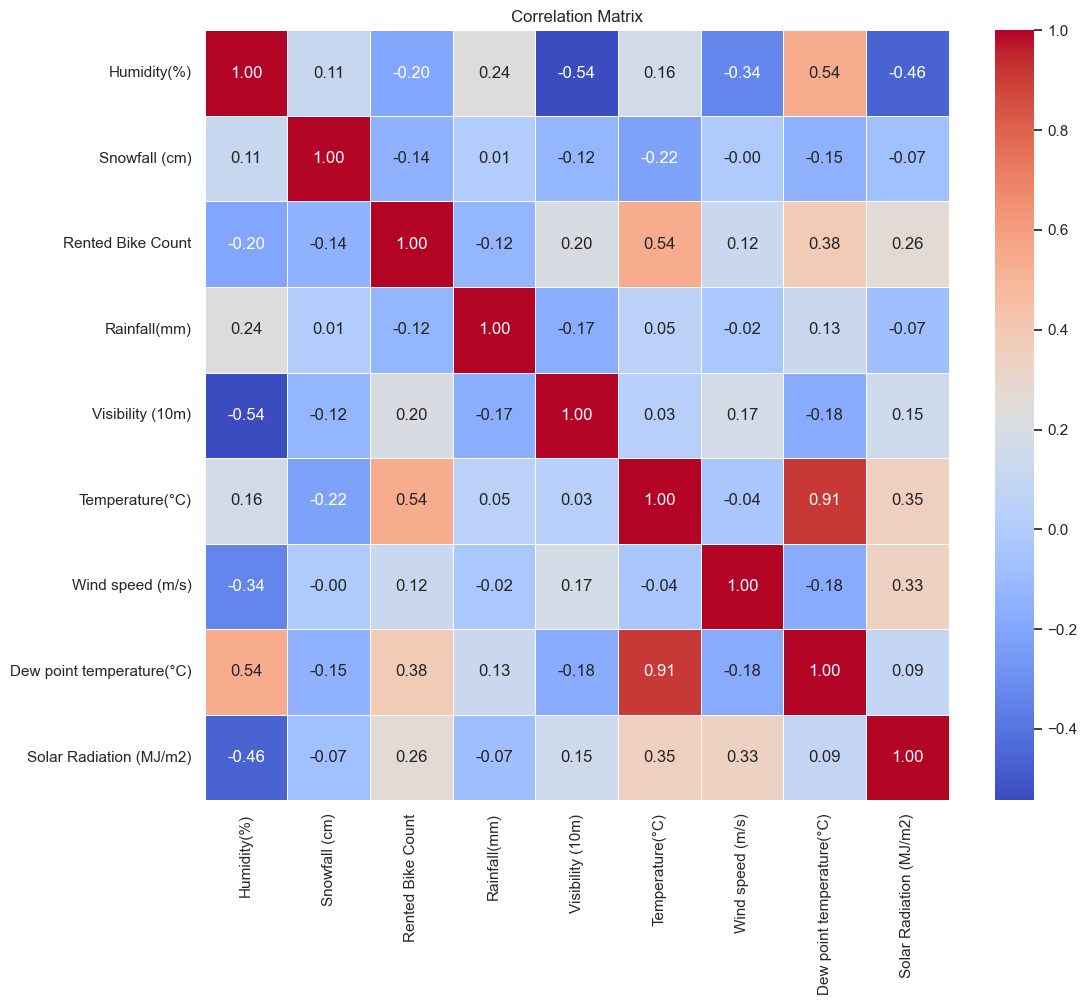

In [238]:
correlation_matrix = d[cols_numeric].corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Create a heatmap of the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)

# Set title
plt.title('Correlation Matrix')

# Show the plot
plt.show()


The above plot shows the correlation matrix of the numeric variables. The things is that to train the lasso model, we also need the non-numeric variables. So we first find these columns and then tranform them and then use them for training. 

We have the final list of categorical columns. So we use them all for the one-hot encoding. We then append the one-hot encoded data to the existing data. We then use this dataframe to train on the encoded and numeric columns.

#### Encoding

In [239]:
d_onehot= pd.get_dummies(d[cols_cat].astype(str), drop_first= True)
dt= pd.concat([d, d_onehot], axis= 1)
cols_train= list(set(cols_numeric+ d_onehot.columns.tolist()))
cols_train.remove('Rented Bike Count')

In [240]:
print('number of training columns', len(cols_train))

number of training columns 42


#### Lasso Regresion

Now that we have the list of the columns, we use the lasso regresion for feature selection. The point is that since Lasso has a term related to the number of the features in the model, some features would have 0 coef. in the Lasso so we can omit them from the model.

The thing is that first we have to tune the lasso parameter so the feature set would be optimal.

For creating this model and also the rest of the analysis, we create training, validation, and test data. We use validation data for the parameter tuning and the test data is only used in the final part for measuring metrics.

In [241]:
train_size= 0.7
valid_size= 0.1
test_size= 1- train_size- valid_size

In [242]:
d= d.sort_values(['Date', 'Hour']).reset_index(drop= True)

index_train= d.head(int(train_size* len(d))).index
index_test= d.tail(int(test_size* len(d))).index
index_valid= d.drop(index_train.tolist()+ index_test.tolist()).index

print('Train Size:', len(index_train))
print('Valid Size:', len(index_valid))
print('Test Size:', len(index_test))


Train Size: 6132
Valid Size: 876
Test Size: 1752


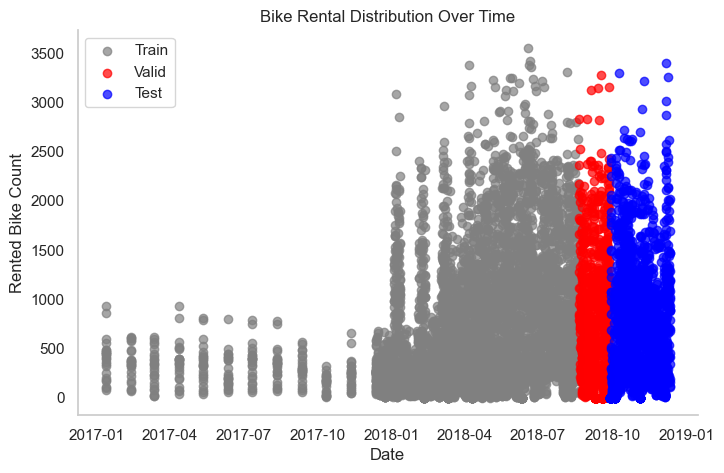

In [243]:

plt.figure(figsize=(8, 5))  # Adjust the figure size as needed

# Scatter plots with minimal aesthetics
plt.scatter(d.iloc[index_train]['Date'], d.iloc[index_train]['Rented Bike Count'], label='Train', color='gray', marker='o', alpha=0.7)
plt.scatter(d.iloc[index_valid]['Date'], d.iloc[index_valid]['Rented Bike Count'], label='Valid', color='red', marker='o', alpha=0.7)
plt.scatter(d.iloc[index_test]['Date'], d.iloc[index_test]['Rented Bike Count'], label='Test', color='blue', marker='o', alpha=0.7)

# Axes labels and title
plt.xlabel('Date')
plt.ylabel('Rented Bike Count')
plt.title('Bike Rental Distribution Over Time')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.legend()

# Remove grid
plt.grid(False)

# Show the plot
plt.show()

In the above chart we can see training, validation, and test data points. We now use the training and validation to find the best alpha for the lasso model.

In [244]:
def lassoCVcustom(
                d, 
                index_train, index_valid, alphas, 
                features, y, score_function):

    scores= []

    for i in range(len(alphas)):
        
        X_train= d.iloc[index_train][features]
        y_train= d.iloc[index_train][y]

        X_valid= d.iloc[index_valid][features]
        y_valid= d.iloc[index_valid][y]

        # we scale features
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_valid = scaler.transform(X_valid)

        model_lasso= Lasso(alpha= alphas[i])
        model_lasso.fit(X_train, y_train)

        y_pred_valid= model_lasso.predict(X_valid)

        score= score_function(y_valid, y_pred_valid)
        scores.append(score)


    results= pd.DataFrame()
    results['Alpha']= alphas
    results['Score']= scores

    return results


In [245]:
y= 'Rented Bike Count'

alpha_lasso= lassoCVcustom(
    d= dt, 
    index_train= index_train, 
    index_valid= index_valid, 
    alphas= np.linspace(start= 0, stop= 10, num= 20), 
    features= cols_train, 
    y= y, 
    score_function= mean_squared_error)

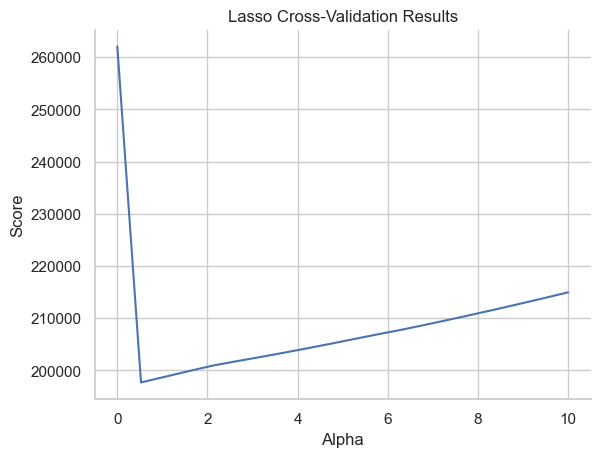

In [246]:
plt.plot(alpha_lasso['Alpha'], alpha_lasso['Score'])

# Axes labels and title
plt.xlabel('Alpha')
plt.ylabel('Score')
plt.title('Lasso Cross-Validation Results')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()


We see that for alpha>0.5, MSE is increasing for alpha. So the best alpha is very small and in the first values.

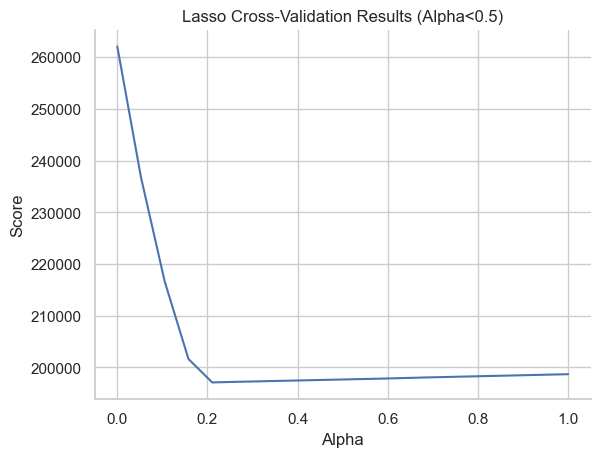

In [247]:
y= 'Rented Bike Count'

alpha_lasso= lassoCVcustom(
    d= dt, 
    index_train= index_train, 
    index_valid= index_valid, 
    alphas= np.linspace(start= 0, stop= 1, num= 20), 
    features= cols_train, 
    y= y, 
    score_function= mean_squared_error)

plt.plot(alpha_lasso['Alpha'], alpha_lasso['Score'])

# Axes labels and title
plt.xlabel('Alpha')
plt.ylabel('Score')
plt.title('Lasso Cross-Validation Results (Alpha<0.5)')

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.show()


In [248]:
alpha_lasso[alpha_lasso['Score']== alpha_lasso['Score'].min()]

,Alpha,Score
4,0.210526,197077.541164


In [249]:
best_alpha_lasso = alpha_lasso[alpha_lasso['Score']== alpha_lasso['Score'].min()]\
                            ['Alpha'].values[0]

Now that we now the alpha, we train the lasso for both the train data and validation data to find features with zero coefficient.

In [250]:
X_train= dt.iloc[index_train.tolist()+ index_valid.tolist()][cols_train]
y_train= dt.iloc[index_train.tolist()+ index_valid.tolist()][y]

# we scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

model_lasso= Lasso(alpha= best_alpha_lasso)
model_lasso.fit(X_train, y_train)

Lasso(alpha=0.21052631578947367)

In [251]:
lasso_coef= pd.DataFrame({'Feature': cols_train, 'Coefficient': model_lasso.coef_})\
    .sort_values('Coefficient')

lasso_coef

,Feature,Coefficient
34,Humidity(%),-190.688224
40,Seasons_Winter,-174.560604
20,Seasons_Spring,-71.865274
9,Hour_4,-70.248977
17,Rainfall(mm),-67.984141
36,Hour_5,-67.660056
12,Seasons_Summer,-64.676122
26,Hour_3,-58.207311
8,Hour_11,-44.034416
3,Hour_10,-42.853398


We see that the coefficient for two variables is so low that we can remove them from the model. We would further use this information for creating linear regresion.

### Part 4

#### Arima Model

since arima is a timeseries model, we only need the time related columns and rented numbers.

In [75]:
d_arima= d.iloc[index_train.tolist()+ index_valid.tolist()][['Date', 'Hour', y]]
d_arima['Datetime'] = d_arima['Date'] + pd.to_timedelta(d_arima['Hour'], unit='h')
d_arima= d_arima[['Datetime', y]].sort_values('Datetime')
d_arima.set_index('Datetime', inplace=True)
d_arima.head()

,Rented Bike Count
Datetime,
2017-01-12 00:00:00,254
2017-01-12 01:00:00,204
2017-01-12 02:00:00,173
2017-01-12 03:00:00,107
2017-01-12 04:00:00,78


We use this data to get arima parameters

In [89]:
model_arima= pm.auto_arima(
    d_arima[y], 
    seasonal=False, 
    suppress_warnings=True,
    test= 'adf',
    max_p= 5, max_q= 5,
    start_p= 1, start_q= 1,
    m= 1,
    d= None,
    start_P= 0,
    D= 0,
    trace= True,
    error_action= 'ignore',
    stepwise= True
)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=98142.202, Time=0.52 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=115961.459, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=98699.525, Time=0.16 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=108495.776, Time=0.65 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=98142.576, Time=0.53 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=98142.198, Time=0.62 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=103987.064, Time=1.06 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=98146.192, Time=0.64 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=98136.168, Time=0.58 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=101828.165, Time=2.29 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=4.59 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=98112.519, Time=2.15 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=100390.116, Time=4.87 sec
 ARIMA(2,0,4)(0,0,0)[0]             : AIC=98111.897, Time=4.26 sec
 ARIMA(3,0,4)(0,0,0)

In [90]:
model_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 7008
Model:               SARIMAX(3, 0, 4)   Log Likelihood              -48728.867
Date:                Fri, 24 Nov 2023   AIC                          97475.734
Time:                        11:36:42   BIC                          97537.427
Sample:                             0   HQIC                         97496.991
                               - 7008                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     76.8715     25.091      3.064      0.002      27.693     126.050
ar.L1          0.4003      0.009     46.503      0.000       0.383       0.417
ar.L2         -0.5150      0.006    -84.182      0.000      -0.527      -0.503
ar.L3          0.9007      0.009     97.508      0.000       0.883       0.919
ma.L1          0.8447      0.013     64.989      0.000       0.819       0.870
ma.L2          1.2285      0.018     69.051      0.000       1.194       1.263
ma.L3          0.3718      0.016     23.287      0.000       0.341       0.403
ma.L4          0.1030      0.014      7.337      0.000       0.075       0.131
sigma2      6.514e+04    749.925     86.864      0.000    6.37e+04    6.66e+04
===================================================================================
Ljung-Box (L1) (Q):                   1.20   Jarque-Bera (JB):              7947.13
Prob(Q):                              0.27   Prob(JB):                         0.00
Heteroskedasticity (H):               3.01   Skew:                            -0.36
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Now we have the best order to use in the arima model, we train a model with that order.

In [91]:
best_arima_order= model_arima.order

In [92]:
model_arima_best= sm.tsa.ARIMA(d_arima, order= best_arima_order)
model_arima_best= model_arima_best.fit()

For saving predictions to further compare them, we create a test dataframe.

In [99]:
d_test= d.iloc[index_test]

In [103]:
y_arima= model_arima_best.predict(
    start= len(d_arima),
    end= len(d_arima)+ len(index_test.tolist())- 1,
    typ= 'levels'
)

y_arima.head()

7008    962.108465
7009    864.407428
7010    789.542694
7011    715.051257
7012    681.634882
Name: predicted_mean, dtype: float64

In [107]:
d_test['y_arima']= y_arima
d_test.head(10)

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day,Quarter,Weekday,y_arima
7008,2018-09-28,0,0,17.1,52,1.4,2000,7.1,0.00,0.0,0.0,Autumn,No Holiday,No,3,4,962.108465
7009,2018-09-28,0,1,16.5,53,1.5,2000,6.8,0.00,0.0,0.0,Autumn,No Holiday,No,3,4,864.407428
7010,2018-09-28,0,2,16.0,56,1.5,2000,7.2,0.00,0.0,0.0,Autumn,No Holiday,No,3,4,789.542694
7011,2018-09-28,0,3,15.3,59,1.6,2000,7.3,0.00,0.0,0.0,Autumn,No Holiday,No,3,4,715.051257
7012,2018-09-28,0,4,14.7,62,1.5,2000,7.4,0.00,0.0,0.0,Autumn,No Holiday,No,3,4,681.634882
7013,2018-09-28,0,5,14.5,60,1.4,2000,6.8,0.00,0.0,0.0,Autumn,No Holiday,No,3,4,694.012522
7014,2018-09-28,0,6,14.4,61,1.2,2000,6.9,0.00,0.0,0.0,Autumn,No Holiday,No,3,4,725.932188
7015,2018-09-28,0,7,14.5,62,1.5,2000,7.2,0.03,0.0,0.0,Autumn,No Holiday,No,3,4,745.368282
7016,2018-09-28,0,8,15.2,58,1.7,2000,6.9,0.29,0.0,0.0,Autumn,No Holiday,No,3,4,737.681305
7017,2018-09-28,0,9,16.5,50,1.2,2000,6.0,0.66,0.0,0.0,Autumn,No Holiday,No,3,4,711.282476


#### Linear Regresion

We use the simple linear regresion and train it on both the train and valid data using the selected features.

In [252]:
selected_features= lasso_coef[lasso_coef['Coefficient']!= 0]['Feature'].tolist()

In [258]:
X_train= dt[dt.index.isin(index_train.tolist()+ index_valid.tolist())][selected_features]
y_train= dt[dt.index.isin(index_train.tolist()+ index_valid.tolist())][y]

X_test= dt[dt.index.isin(index_test)][selected_features]

# we scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model_LR= LinearRegression()
model_LR.fit(X_train, y_train)

y_LR= model_LR.predict(X_test)


In [259]:
d_test['y_LR']= y_LR
d_test.head(10)

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day,Quarter,Weekday,y_arima,y_LR,y_rf
7008,2018-09-28,0,0,17.1,52,1.4,2000,7.1,0.00,0.0,0.0,Autumn,No Holiday,No,3,4,962.108465,92.741518,157.270
7009,2018-09-28,0,1,16.5,53,1.5,2000,6.8,0.00,0.0,0.0,Autumn,No Holiday,No,3,4,864.407428,-5.323443,111.425
7010,2018-09-28,0,2,16.0,56,1.5,2000,7.2,0.00,0.0,0.0,Autumn,No Holiday,No,3,4,789.542694,-165.412444,64.245
7011,2018-09-28,0,3,15.3,59,1.6,2000,7.3,0.00,0.0,0.0,Autumn,No Holiday,No,3,4,715.051257,-256.144360,32.010
7012,2018-09-28,0,4,14.7,62,1.5,2000,7.4,0.00,0.0,0.0,Autumn,No Holiday,No,3,4,681.634882,-321.085670,8.360
7013,2018-09-28,0,5,14.5,60,1.4,2000,6.8,0.00,0.0,0.0,Autumn,No Holiday,No,3,4,694.012522,-330.353708,7.675
7014,2018-09-28,0,6,14.4,61,1.2,2000,6.9,0.00,0.0,0.0,Autumn,No Holiday,No,3,4,725.932188,-201.531684,96.580
7015,2018-09-28,0,7,14.5,62,1.5,2000,7.2,0.03,0.0,0.0,Autumn,No Holiday,No,3,4,745.368282,105.977830,226.950
7016,2018-09-28,0,8,15.2,58,1.7,2000,6.9,0.29,0.0,0.0,Autumn,No Holiday,No,3,4,737.681305,506.311412,65.920
7017,2018-09-28,0,9,16.5,50,1.2,2000,6.0,0.66,0.0,0.0,Autumn,No Holiday,No,3,4,711.282476,213.286050,0.000


#### Random Forrest

For the random forrest, we add some new features since it can handle overfitting very well. The thing is that we have a time series data and historical data can provide the model a good prediction power. So we use lags from the past days as a new feature.

In the last part, we should use the model to predict the demand for the next coming days. so lag features should come from days that are 3 or more days before.

Each row in data shows an hour. So we can use lags from 3*24 hours before or more.

In [128]:
lags= [3* 24, 3* 25, 3* 26, 4* 24, 4* 25, 4* 26, 5* 24, 6* 24, 7* 24]
for lag in lags:
    dt['lag_'+ str(lag)]= dt.shift(lag)[y]

these lags would have some nan values:

In [132]:
cols_lag= [col for col in dt.columns if 'lag' in col]
dt[cols_lag].isna().sum()

lag_72      72
lag_75      75
lag_78      78
lag_96      96
lag_100    100
lag_104    104
lag_120    120
lag_144    144
lag_168    168
dtype: int64

Since the number of the nan values are not too much, we drop them.

In [133]:
dt= dt.dropna()

Now we can use this dataframe for finding hyperparameters of the random forrest.

In [167]:
def find_best_params(data, index_train, index_valid, features, y, param_grid, model):


    # Initialize Random Forest Regressor
    grid_search = GridSearchCV(model, 
                           param_grid, 
                           scoring='neg_mean_squared_error', 
                           cv= [[index_train.tolist(), index_valid.tolist()]],
                           verbose= 3,
                           n_jobs= -1,
                           return_train_score=True
                           )

    
    # Fit the model on the training data
    grid_search.fit(data[features],
                    data[y])

    # Get the best parameters
    best_params = grid_search.best_params_
    
    print(f"Best Parameters: {best_params}")
    
    return best_params


we choose n_estimators to be 200 as a normal number. We hypertune with this and then increae the number of trees.
It is obvious that increasing the number of trees would reduce the overfitting and both the test and train error and the only matter for increasing the number of trees is time.
 


In [169]:
model = RandomForestRegressor()

param_grid = {
    'n_estimators': [200],
    'max_depth': [None, 3, 5, 8, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [170]:
rf_params= find_best_params(data= dt, 
                            index_train= index_train,
                            index_valid= index_valid, 
                            features= cols_train+ cols_lag, 
                            y= y, 
                            param_grid= param_grid, 
                            model= model
                            )

Fitting 1 folds for each of 45 candidates, totalling 45 fits
Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}


Now that we know the parameters, we train the final random forrest model on both the train and valid data.

In [197]:
# increasing the trees
rf_params['n_estimators']= 100
model_rf= RandomForestRegressor(n_estimators= 200)

model_rf.fit(
    dt.iloc[index_train.tolist()+ index_valid.tolist()][cols_train], 
    dt.iloc[index_train.tolist()+ index_valid.tolist()][y])

RandomForestRegressor(n_estimators=200)

In [198]:
y_rf= model_rf.predict(
    dt[dt.index.isin(index_test)][cols_train]
)

d_test['y_rf']= y_rf

#### Comparison

Now that we have all the models trained, we should calculate metrics to check their performance.

In [187]:
models= ['y_LR', 'y_arima', 'y_rf']
y= 'Rented Bike Count'

In [260]:
d_test[models]= d_test[models].mask(d_test[models]<0, 0)

In [261]:
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

# and models is the list of model names

# List to store results
results = []

# Calculate metrics for each model
for model in models:
    # Extract actual and predicted values
    y_actual = d_test['Rented Bike Count']
    y_pred = d_test[model]

    # Calculate MSE
    mse = mean_squared_error(y_actual, y_pred)

    # Calculate R-squared
    r2 = r2_score(y_actual, y_pred)

    # Calculate adjusted R-squared
    n = len(d_test)
    k = 1  # Assuming one predictor variable (you may need to adjust this based on your actual model)
    r2_adjusted = 1 - ((1 - r2) * (n - 1) / (n - k - 1))

    # Store results
    results.append({
        'Model': model,
        'MSE': mse,
        'R-squared': r2,
        'Adjusted R-squared': r2_adjusted
    })

# Create a DataFrame from the results
results_df = pd.DataFrame(results)

# Display the results
print(results_df)


     Model            MSE  R-squared  Adjusted R-squared
0     y_LR  336328.455581   0.096295            0.095779
1  y_arima  379781.284373  -0.020461           -0.021044
2     y_rf  444342.409192  -0.193935           -0.194617


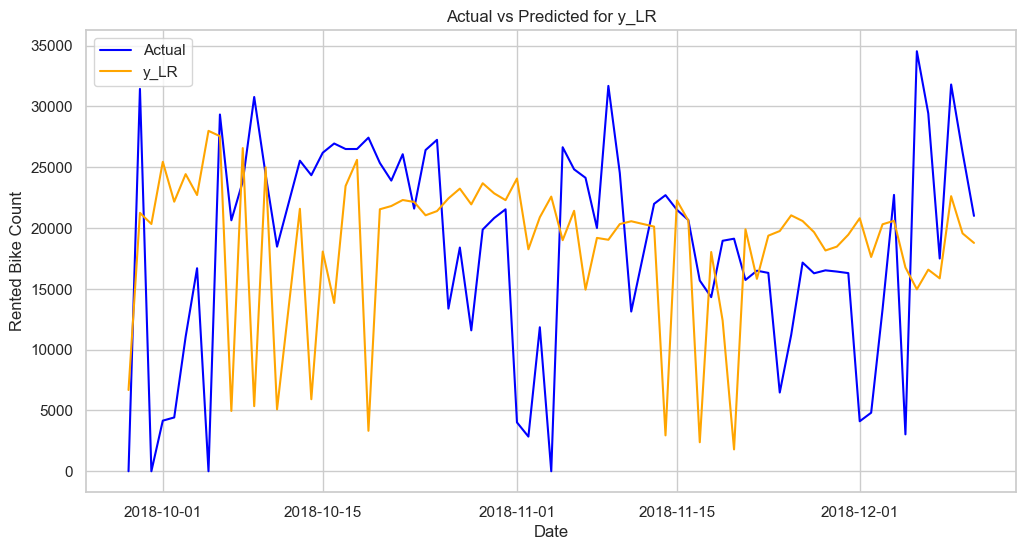

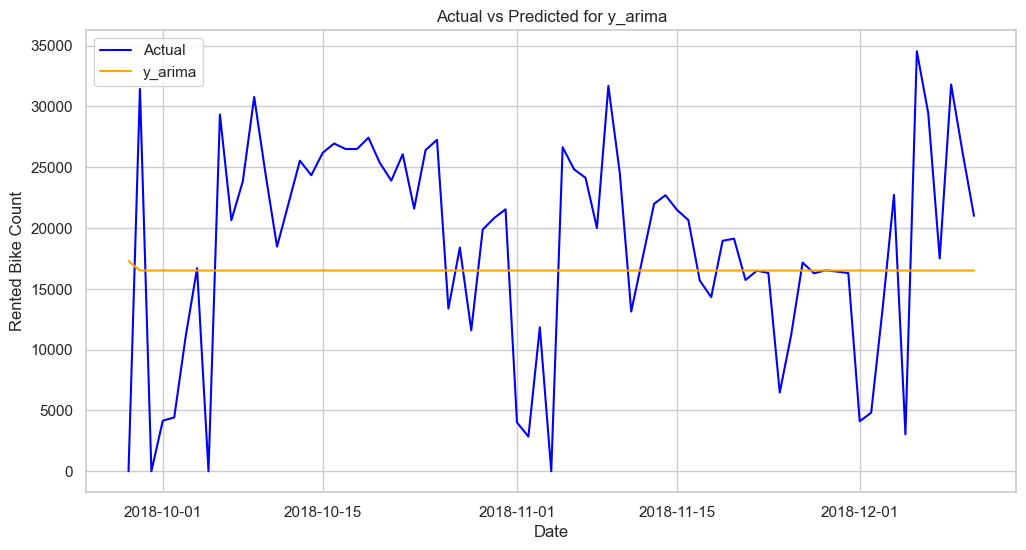

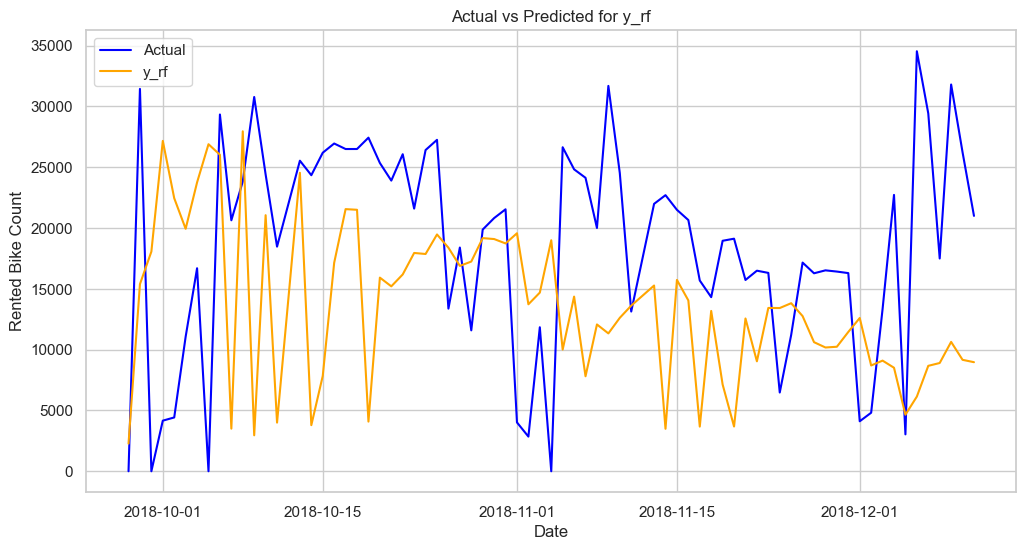

In [205]:
import matplotlib.pyplot as plt
import seaborn as sns  # Optional, but it enhances the plot aesthetics

# Assuming d_test is your DataFrame with actual and predicted values,
# models is the list of model names, and 'Date' is a column in d_test

# Set the style for better aesthetics (optional)
sns.set(style="whitegrid")
d_plot= d_test.groupby('Date', as_index= False).sum()
# Plot actual vs predicted values for each model
for model in models:
    plt.figure(figsize=(12, 6))
    
    # Plot actual values
    plt.plot(d_plot['Date'], d_plot['Rented Bike Count'], label='Actual', color='blue')

    # Plot predicted values
    plt.plot(d_plot['Date'], d_plot[model], label=model, color='orange')

    plt.title(f"Actual vs Predicted for {model}")
    plt.xlabel('Date')
    plt.ylabel('Rented Bike Count')
    plt.legend()
    plt.show()
